In [1]:
%load_ext autoreload
%autoreload 2

In [152]:
import pandas as pd
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
import numpy as np
import random
from tqdm import tqdm
from deepmatch.models import ComiRec, NCF, YoutubeDNN, MIND
from deepmatch.utils import sampledsoftmaxloss, NegativeSampler
import tensorflow as tf
import gc

from deepctr.feature_column import DenseFeat

pad_sequences = tf.keras.utils.pad_sequences
SEQ_LEN = 10

In [153]:
import load_data

In [154]:
data, movies = load_data.load_25m()

In [14]:
data, movies = load_data.load_1m()

/root/workspace/IRS-PM-2024-01-13-IS06PT-GRP-CinePaw-Recommender/SystemCode/experiments/load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  user = pd.read_csv(data_path+'ml-1m/users.dat',sep='::',header=None,names=unames)
/root/workspace/IRS-PM-2024-01-13-IS06PT-GRP-CinePaw-Recommender/SystemCode/experiments/load_data.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(data_path+'ml-1m/ratings.dat',sep='::',header=None,names=rnames)
/root/workspace/IRS-PM-2024-01-13-IS06PT-GRP-CinePaw-Recommender/SystemCode/experiments/load_data.py:76: ParserWarning: Falling back to the

In [155]:
movies

,movieId,title,genres,hot,grade,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,3,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,4,3,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,4,3,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,2,1995
4,5,Father of the Bride Part II (1995),Comedy,4,3,1995
...,...,...,...,...,...,...
59042,209157,We (2018),Drama,1,1,2018
59043,209159,Window of the Soul (2001),Documentary,1,2,2001
59044,209163,Bad Poems (2018),Comedy|Drama,1,4,2018
59045,209169,A Girl Thing (2001),(no genres listed),1,2,2001


In [156]:
lbe = LabelEncoder()

In [157]:
movies["int_genres"] = lbe.fit_transform(movies["genres"]) + 1

In [158]:
data["genres"] = lbe.transform(data["genres"])+1

In [161]:
data["userId"] = data["user_id"]
data["movieId"] = data["movie_id"]

In [162]:
user_id_size =  data['userId'].max()+1
movie_id_size = data['movieId'].max()+1
genre_id_size = int(data['genres'].max())+1
grade_size = int(data['grade'].max()) + 1
hot_size = int(data['hot'].max()) + 1
year_size = int(data['year'].max()) + 1
embedding_dim = 64

In [163]:
user_feature_columns = [
                        # SparseFeat('user_id', user_id_size, 16),
                        VarLenSparseFeat(SparseFeat('hist_movie_id', movie_id_size, embedding_dim,
                                                    embedding_name="movie_id"), SEQ_LEN, 'mean', 'hist_len'),
                        VarLenSparseFeat(SparseFeat('hist_genres', genre_id_size, embedding_dim,
                                                   embedding_name="genres"), SEQ_LEN, 'mean', 'hist_len'),
                        VarLenSparseFeat(SparseFeat('hist_hot', genre_id_size, embedding_dim,
                                                   embedding_name="hot"), SEQ_LEN, 'mean', 'hist_len'),
                            VarLenSparseFeat(SparseFeat('hist_grade', genre_id_size, embedding_dim,
                                                   embedding_name="grade"), SEQ_LEN, 'mean', 'hist_len'),
                        VarLenSparseFeat(SparseFeat('hist_year', year_size, embedding_dim,
                                                   embedding_name="year"), SEQ_LEN, 'mean', 'hist_len'),
                        ]
item_feature_columns = [SparseFeat('movie_id', movie_id_size, embedding_dim),]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [164]:
def get_train_input_for_user(user_df):
    user_df = user_df.sort_values("timestamp")
    user_df = user_df[-50:] 
    user_id = user_df["user_id"].to_list()[0]
    tmp = [user_df[:x+1] for x in range(len(user_df))]
    input_data = []
    for record in tmp:
        sample = {
            "history_movie_id":np.array(record["movie_id"].tolist()[:-1]),
            "history_genre_id": np.array(record["genres"].tolist()[:-1]),
            "history_hot":np.array(record["hot"].tolist()[:-1]),
            "history_grade": np.array(record["grade"].tolist()[:-1]),
            "history_year": np.array(record["year"].tolist()[:-1]),
            "movie_id":np.array(record["movie_id"].tolist()[-1]),
            # np.array(record["genres"].tolist()[:-1]) # history genre list
        }
        input_data.append(sample)
    # train, test = input_data[:-1], input_data[-1:]
    result_df = pd.DataFrame(input_data)
    result_df["label"] = 1 # tmp for now
    result_df["hist_len"] = SEQ_LEN
    result_df[["label", "hist_len"]] = result_df[["label", "hist_len"]].astype("int8")
    return result_df

def get_test_input_for_user(user_df):
    #user_df = user_df.sort_values("timestamp")
    # user_df = user_df[-SEQ_LEN:] 
    user_id = user_df["user_id"].to_list()[0]
    
    input_data = []
    record = user_df
    sample = {
        "history_movie_id":np.array(record["movie_id"].tolist()[:-1]),
        "history_genre_id": np.array(record["genres"].tolist()[:-1]),
            "history_hot":np.array(record["hot"].tolist()[:-1]),
            "history_grade": np.array(record["grade"].tolist()[:-1]),
        "history_year": np.array(record["year"].tolist()[:-1]),
        "movie_id":np.array(record["movie_id"].tolist()[-1]),
        # np.array(record["genres"].tolist()[:-1]) # history genre list
    }
    input_data.append(sample)
    # train, test = input_data[:-1], input_data[-1:]
    result_df = pd.DataFrame(input_data)
    result_df["label"] = 1 # tmp for now
    result_df["hist_len"] = SEQ_LEN
    return result_df

In [165]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
tqdm.pandas()
SEQ_LEN=10

In [166]:
data["user_id"] = data["userId"]
data["movie_id"] = data["movieId"]

In [167]:
df = data.groupby("user_id").progress_apply(lambda x:get_test_input_for_user(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162541/162541 [00:59<00:00, 2734.33it/s]


In [168]:
train_set = data.groupby("user_id").progress_apply(lambda x:get_train_input_for_user(x))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162541/162541 [11:32<00:00, 234.55it/s]


In [169]:
test_set = data.groupby("user_id").progress_apply(lambda x:get_test_input_for_user(x))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162541/162541 [01:02<00:00, 2617.19it/s]


In [174]:
def construct_input(df):
    df["history_movie_id"] = pad_sequences(df["history_movie_id"], maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0).tolist()
    df["history_genre_id"] = pad_sequences(df["history_genre_id"], maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0).tolist()
    df["history_hot"] = pad_sequences(df["history_hot"], maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0).tolist()
    df["history_grade"] = pad_sequences(df["history_grade"], maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0).tolist()
    df["history_year"] = pad_sequences(df["history_year"], maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0).tolist()
    
    df = df.sample(frac=1)
    
    model_input = {
        "hist_movie_id":np.array(df["history_movie_id"].tolist()),
        "hist_genres":np.array(df["history_genre_id"].tolist()),
        "hist_hot":np.array(df["history_hot"].tolist()),
        "hist_grade":np.array(df["history_grade"].tolist()),
        "hist_year":np.array(df["history_year"].tolist()),
        "movie_id": np.array(df["movie_id"].tolist()),
        "hist_len": np.array(df["hist_len"].tolist()),
    }
    label =  df["label"].tolist()
    return model_input, label

In [175]:
train_model_input, train_label = construct_input(train_set)

In [171]:
test_model_input, test_label = construct_input(test_set)

## COMI REC

In [ ]:
import tensorflow as tf
if tf.__version__ >= '2.0.0':
    tf.compat.v1.disable_eager_execution()
else:
    K.set_learning_phase(True)

from collections import Counter
train_counter = Counter(data['movie_id'])
item_count = [int(math.sqrt(train_counter.get(i,0))) for i in range(item_feature_columns[0].vocabulary_size)] 
sampler_config = NegativeSampler('frequency',num_sampled=255,item_name="movie_id",item_count=item_count)
#model = YoutubeDNN(user_feature_columns, item_feature_columns, user_dnn_hidden_units=(128,64, embedding_dim), sampler_config=sampler_config)
model = ComiRec(user_feature_columns,
                item_feature_columns,
                k_max=2, 
                interest_extractor="dr",
                user_dnn_hidden_units=(128,64, embedding_dim),
                sampler_config=sampler_config)


model.compile(optimizer="adam", loss=sampledsoftmaxloss)
history = model.fit(train_model_input, train_label,  # train_label,
                    batch_size=512, epochs=20, verbose=1, validation_split=0.01, use_multiprocessing=True)

Train on 6947119 samples, validate on 70173 samples
Epoch 1/20


2024-04-25 23:38:17.859040: W tensorflow/c/c_api.cc:291] Operation '{name:'training_22/Adam/sparse_seq_emb_hist_hot_11/embeddings/v/Assign' id:22821 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/sparse_seq_emb_hist_hot_11/embeddings/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/sparse_seq_emb_hist_hot_11/embeddings/v, training_22/Adam/sparse_seq_emb_hist_hot_11/embeddings/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


6947119/6947119 [==============================] - ETA: 0s - loss: 3.8241

2024-04-26 00:21:05.786251: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_11/AddN_1' id:21818 op device:{requested: '', assigned: ''} def:{{{node loss_11/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_11/mul, loss_11/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


6947119/6947119 [==============================] - 2581s 372us/sample - loss: 3.8241 - val_loss: 3.3839
Epoch 2/20
6947119/6947119 [==============================] - 2575s 371us/sample - loss: 3.0718 - val_loss: 3.0874
Epoch 15/20
6055424/6947119 [=========================>....] - ETA: 5:28 - loss: 3.0669

In [ ]:
1

## YoutubeDNN

In [74]:
import math

In [75]:
import tensorflow as tf
from deepmatch.models import ComiRec, NCF, YoutubeDNN
if tf.__version__ >= '2.0.0':
    tf.compat.v1.disable_eager_execution()
else:
    K.set_learning_phase(True)

from collections import Counter
train_counter = Counter(data['movie_id'])
item_count = [int(math.sqrt(train_counter.get(i,0))) for i in range(item_feature_columns[0].vocabulary_size)] #todo change this later
sampler_config = NegativeSampler('frequency',num_sampled=255,item_name="movie_id",item_count=item_count)
#model = YoutubeDNN(user_feature_columns, item_feature_columns, user_dnn_hidden_units=(128,64, embedding_dim), sampler_config=sampler_config)
model = YoutubeDNN(user_feature_columns,
                item_feature_columns,
                user_dnn_hidden_units=(128,64, embedding_dim),
                sampler_config=sampler_config)


model.compile(optimizer="adam", loss=sampledsoftmaxloss)
history = model.fit(train_model_input, train_label,  # train_label,
                    batch_size=512, epochs=20, verbose=1, validation_split=0.01, use_multiprocessing=True)

Train on 268872 samples, validate on 2716 samples
Epoch 1/20
   512/268872 [..............................] - ETA: 2:02 - loss: 9.3321

2024-04-21 16:52:51.212496: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/Adam/dnn/bias2/v/Assign' id:3290 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dnn/bias2/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dnn/bias2/v, training_2/Adam/dnn/bias2/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


268872/268872 [==============================] - 4s 13us/sample - loss: 6.4510 - val_loss: 5.1434
Epoch 2/20
  5120/268872 [..............................] - ETA: 3s - loss: 5.1445

/root/.cache/pypoetry/virtualenvs/cinepaw-P6zxCTLW-py3.10/lib/python3.10/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-04-21 16:52:54.606500: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/AddN_1' id:2463 op device:{requested: '', assigned: ''} def:{{{node loss_1/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul, loss_1/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


268872/268872 [==============================] - 3s 12us/sample - loss: 4.7482 - val_loss: 4.4889
Epoch 3/20
268872/268872 [==============================] - 3s 12us/sample - loss: 4.3956 - val_loss: 4.3352
Epoch 4/20
268872/268872 [==============================] - 3s 12us/sample - loss: 4.2289 - val_loss: 4.2007
Epoch 5/20
268872/268872 [==============================] - 3s 12us/sample - loss: 4.1280 - val_loss: 4.1267
Epoch 6/20
268872/268872 [==============================] - 3s 12us/sample - loss: 4.0506 - val_loss: 4.0973
Epoch 7/20
268872/268872 [==============================] - 3s 12us/sample - loss: 3.9842 - val_loss: 4.1096
Epoch 8/20
268872/268872 [==============================] - 3s 12us/sample - loss: 3.9371 - val_loss: 4.0882
Epoch 9/20
268872/268872 [==============================] - 3s 12us/sample - loss: 3.8890 - val_loss: 4.0013
Epoch 10/20
268872/268872 [==============================] - 3s 12us/sample - loss: 3.8511 - val_loss: 3.9993
Epoch 11/20
268872/268872 [==

## MIND

In [143]:
import tensorflow as tf
from deepmatch.models import ComiRec, NCF, YoutubeDNN
if tf.__version__ >= '2.0.0':
    tf.compat.v1.disable_eager_execution()
else:
    K.set_learning_phase(True)

from collections import Counter
train_counter = Counter(data['movie_id'])
item_count = [int(math.sqrt(train_counter.get(i,0))) for i in range(item_feature_columns[0].vocabulary_size)] #todo change this later
sampler_config = NegativeSampler('frequency',num_sampled=255,item_name="movie_id",item_count=item_count)
#model = YoutubeDNN(user_feature_columns, item_feature_columns, user_dnn_hidden_units=(128,64, embedding_dim), sampler_config=sampler_config)
model = MIND(user_feature_columns,
                item_feature_columns,
                 k_max=2,
                user_dnn_hidden_units=(128,64, embedding_dim),
                sampler_config=sampler_config)


model.compile(optimizer="adam", loss=sampledsoftmaxloss)
history = model.fit(train_model_input, train_label,  # train_label,
                    batch_size=512, epochs=20, verbose=1, validation_split=0.01, use_multiprocessing=True)

Train on 268872 samples, validate on 2716 samples
Epoch 1/20


2024-04-21 17:56:30.270277: W tensorflow/c/c_api.cc:291] Operation '{name:'training_18/Adam/sparse_seq_emb_hist_year_9/embeddings/v/Assign' id:18849 op device:{requested: '', assigned: ''} def:{{{node training_18/Adam/sparse_seq_emb_hist_year_9/embeddings/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_18/Adam/sparse_seq_emb_hist_year_9/embeddings/v, training_18/Adam/sparse_seq_emb_hist_year_9/embeddings/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


266752/268872 [============================>.] - ETA: 0s - loss: 5.3665

2024-04-21 17:56:36.505389: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_9/AddN_1' id:17832 op device:{requested: '', assigned: ''} def:{{{node loss_9/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul, loss_9/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


268872/268872 [==============================] - 7s 25us/sample - loss: 5.3638 - val_loss: 5.0405
Epoch 2/20
268872/268872 [==============================] - 6s 22us/sample - loss: 4.8848 - val_loss: 4.6722
Epoch 3/20
268872/268872 [==============================] - 6s 22us/sample - loss: 4.5596 - val_loss: 4.4381
Epoch 4/20
268872/268872 [==============================] - 6s 22us/sample - loss: 4.3421 - val_loss: 4.2988
Epoch 5/20
268872/268872 [==============================] - 6s 22us/sample - loss: 4.2063 - val_loss: 4.2222
Epoch 6/20
268872/268872 [==============================] - 6s 22us/sample - loss: 4.1210 - val_loss: 4.1452
Epoch 7/20
268872/268872 [==============================] - 6s 22us/sample - loss: 4.0580 - val_loss: 4.1355
Epoch 8/20
268872/268872 [==============================] - 6s 22us/sample - loss: 4.0006 - val_loss: 4.0729
Epoch 9/20
268872/268872 [==============================] - 6s 22us/sample - loss: 3.9571 - val_loss: 4.0206
Epoch 10/20
268872/268872 [===

## Single Test

In [34]:
from scipy.spatial.distance import cdist

In [35]:
all_movie_ids = movies["movieId"]
metadatas = movies.to_dict(orient="records")

all_item_model_input = {"movie_id": all_movie_ids}

user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)

#user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
# user_embs = user_embs[:, i, :]  # i in [0,k_max) if MIND
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)

/root/.cache/pypoetry/virtualenvs/cinepaw-P6zxCTLW-py3.10/lib/python3.10/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-04-21 13:28:58.558053: W tensorflow/c/c_api.cc:291] Operation '{name:'lambda_3/Squeeze' id:643 op device:{requested: '', assigned: ''} def:{{{node lambda_3/Squeeze}} = Squeeze[T=DT_FLOAT, _has_manual_control_dependencies=true, squeeze_dims=[1]](lambda_3/GatherV2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [36]:
movies[(movies["genres"]=="Horror")&(movies["year"]>1970)]\
    .sort_values(["hot"]).tail(10)

,movieId,title,genres,hot,grade,year,int_genres
1789,1969,Nightmare on Elm Street Part 2: Freddy's Reven...,Horror,2,2,1985,275
1790,1970,"Nightmare on Elm Street 3: Dream Warriors, A (...",Horror,2,2,1987,275
2319,2514,Pet Sematary II (1992),Horror,2,2,1992,275
2318,2513,Pet Sematary (1989),Horror,2,2,1989,275
1791,1971,"Nightmare on Elm Street 4: The Dream Master, A...",Horror,2,2,1988,275
1792,1972,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror,2,1,1989,275
1793,1973,Freddy's Dead: The Final Nightmare (1991),Horror,2,2,1991,275
2322,2517,Christine (1983),Horror,2,3,1983,275
2505,2710,"Blair Witch Project, The (1999)",Horror,3,3,1999,275
1166,1258,"Shining, The (1980)",Horror,3,4,1980,275


In [37]:
watched_titles = ["Blair Witch Project, The (1999)", "Exorcist, The (1973)", "Friday the 13th Part V: A New Beginning (1985)"]

In [38]:
watched_titles = movies[(movies["genres"]=="Horror")&(movies["year"]>1990)]\
    .sort_values(["hot"]).tail(10)["title"].tolist()

In [39]:
watched_titles = watched_titles[0:10]

In [40]:
user_df = movies[movies["title"].isin(watched_titles)]
user_df["genres"] = lbe.transform(user_df["genres"]) + 1
model_input = {
    "hist_movie_id": pad_sequences(np.array([user_df["movieId"].tolist()]), maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0),
    "hist_genres": pad_sequences(np.array([user_df["genres"].tolist()]), maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0),
    "hist_hot": pad_sequences(np.array([user_df["hot"].tolist()]), maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0),
    "hist_grade": pad_sequences(np.array([user_df["grade"].tolist()]), maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0),
    "hist_year": pad_sequences(np.array([user_df["year"].tolist()]), maxlen=SEQ_LEN, padding='pre', truncating='pre', value=0),
    "hist_len": np.array([len(user_df["genres"].tolist())])
}

/tmp/ipykernel_2789777/3737173683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df["genres"] = lbe.transform(user_df["genres"]) + 1


In [41]:
user_embs = user_embedding_model.predict(model_input, batch_size=2 ** 12)

/root/.cache/pypoetry/virtualenvs/cinepaw-P6zxCTLW-py3.10/lib/python3.10/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-04-21 13:29:10.092720: W tensorflow/c/c_api.cc:291] Operation '{name:'user_dnn/dropout_4/cond/Identity' id:461 op device:{requested: '', assigned: ''} def:{{{node user_dnn/dropout_4/cond/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](user_dnn/dropout_4/cond)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [42]:
watched_titles

['Tales from the Crypt Presents: Bordello of Blood (1996)',
 "Wes Craven's New Nightmare (1994)",
 'Pet Sematary II (1992)',
 'Candyman (1992)',
 'Vampires (1998)',
 'Wishmaster (1997)',
 "Freddy's Dead: The Final Nightmare (1991)",
 'Relic, The (1997)',
 'Tales From the Crypt Presents: Demon Knight (1995)',
 'Blair Witch Project, The (1999)']

In [46]:
matrix = item_embs
distance = cdist(np.array([user_embs[0][0]]), matrix).min(axis=0)
movies["distance"] = distance
movies.sort_values("distance").head(20)

,movieId,title,genres,hot,grade,year,int_genres,distance
320,330,Tales from the Hood (1995),Comedy|Horror,2,2,1995,197,16.586804
831,891,Halloween: The Curse of Michael Myers (1995),Horror|Thriller,2,2,1995,281,16.591472
356,366,Wes Craven's New Nightmare (1994),Horror,2,2,1994,275,16.613286
1793,1973,Freddy's Dead: The Final Nightmare (1991),Horror,2,2,1991,275,16.632660
1926,2107,Halloween: H20 (1998),Horror|Thriller,2,2,1998,281,16.634372
596,611,Hellraiser: Bloodline (1996),Action|Horror|Sci-Fi,2,2,1996,77,16.654623
68,70,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller,2,3,1996,47,16.660159
1244,1342,Candyman (1992),Horror,2,2,1992,275,16.667507
190,196,Species (1995),Horror|Sci-Fi,2,2,1995,279,16.671106
318,328,Tales From the Crypt Presents: Demon Knight (1...,Horror,2,3,1995,275,16.685303


In [44]:
matrix = item_embs
distance = cdist(np.array([user_embs[0][1]]), matrix).min(axis=0)
movies["distance"] = distance
movies.sort_values("distance").head(20)

,movieId,title,genres,hot,grade,year,int_genres,distance
31,32,Twelve Monkeys (1995),Drama|Sci-Fi,3,3,1995,259,21.591556
1305,1407,Scream (1996),Horror|Thriller,2,3,1996,281,21.636694
3266,3499,Misery (1990),Horror,2,3,1990,275,21.638495
33,34,Babe (1995),Children's|Comedy|Drama,3,3,1995,162,21.641369
1703,1883,Bulworth (1998),Comedy,2,3,1998,177,21.643138
0,1,Toy Story (1995),Animation|Children's|Comedy,3,4,1995,146,21.645989
3238,3471,Close Encounters of the Third Kind (1977),Drama|Sci-Fi,3,4,1977,259,21.648958
1099,1188,Strictly Ballroom (1992),Comedy|Romance,2,3,1992,208,21.650224
1438,1565,Head Above Water (1996),Comedy|Thriller,1,2,1996,214,21.652230
576,590,Dances with Wolves (1990),Adventure|Drama|Western,3,3,1990,131,21.655299


In [431]:
watched_titles

["Nightmare on Elm Street Part 2: Freddy's Revenge, A (1985)",
 'Nightmare on Elm Street 3: Dream Warriors, A (1987)',
 'Pet Sematary II (1992)',
 'Pet Sematary (1989)',
 'Nightmare on Elm Street 4: The Dream Master, A (1988)',
 'Nightmare on Elm Street 5: The Dream Child, A (1989)',
 "Freddy's Dead: The Final Nightmare (1991)",
 'Christine (1983)',
 'Blair Witch Project, The (1999)',
 'Shining, The (1980)']

In [458]:
ComiRec

<function deepmatch.models.comirec.ComiRec(user_feature_columns, item_feature_columns, k_max=2, p=100, interest_extractor='sa', add_pos=True, user_dnn_hidden_units=(64, 32), dnn_activation='relu', dnn_use_bn=False, l2_reg_dnn=0, l2_reg_embedding=1e-06, dnn_dropout=0, output_activation='linear', sampler_config=None, seed=1024)>

In [ ]:
item

In [116]:
import chromadb
chroma_client = chromadb.PersistentClient(path="./chroma_data")
collection = chroma_client.get_or_create_collection("movie_rec_25m_0421")
#collection.delete(ids=all_movie_ids.apply(str).tolist()[:30000])
#collection.delete(ids=all_movie_ids.apply(str).tolist()[30000:])
collection = chroma_client.get_or_create_collection("movie_rec_25m_0421")


collection.add(ids=all_movie_ids.apply(str).tolist()[:30000],
               embeddings=item_embs[:30000],
               metadatas=metadatas[:30000])
collection.add(ids=all_movie_ids.apply(str).tolist()[30000:],
               embeddings=item_embs[30000:],
               metadatas=metadatas[30000:])

In [117]:
from tensorflow.python.keras.models import  save_model,load_model
from deepmatch.layers import custom_objects
save_model(user_embedding_model, 'user_emb_25m_0421.h5')

/root/.cache/pypoetry/virtualenvs/cinepaw-P6zxCTLW-py3.10/lib/python3.10/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [108]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_index (EmbeddingIndex (209172,)            0           movie_id[0][0]                   
__________________________________________________________________________________________________
hist_movie_id (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
sparse_seq_emb_hist_movie_id (E multiple             13387008    movie_id[0][0]                   
                                                                 hist_movie_id[0][0]          

In [5]:
import pydot
import graphviz

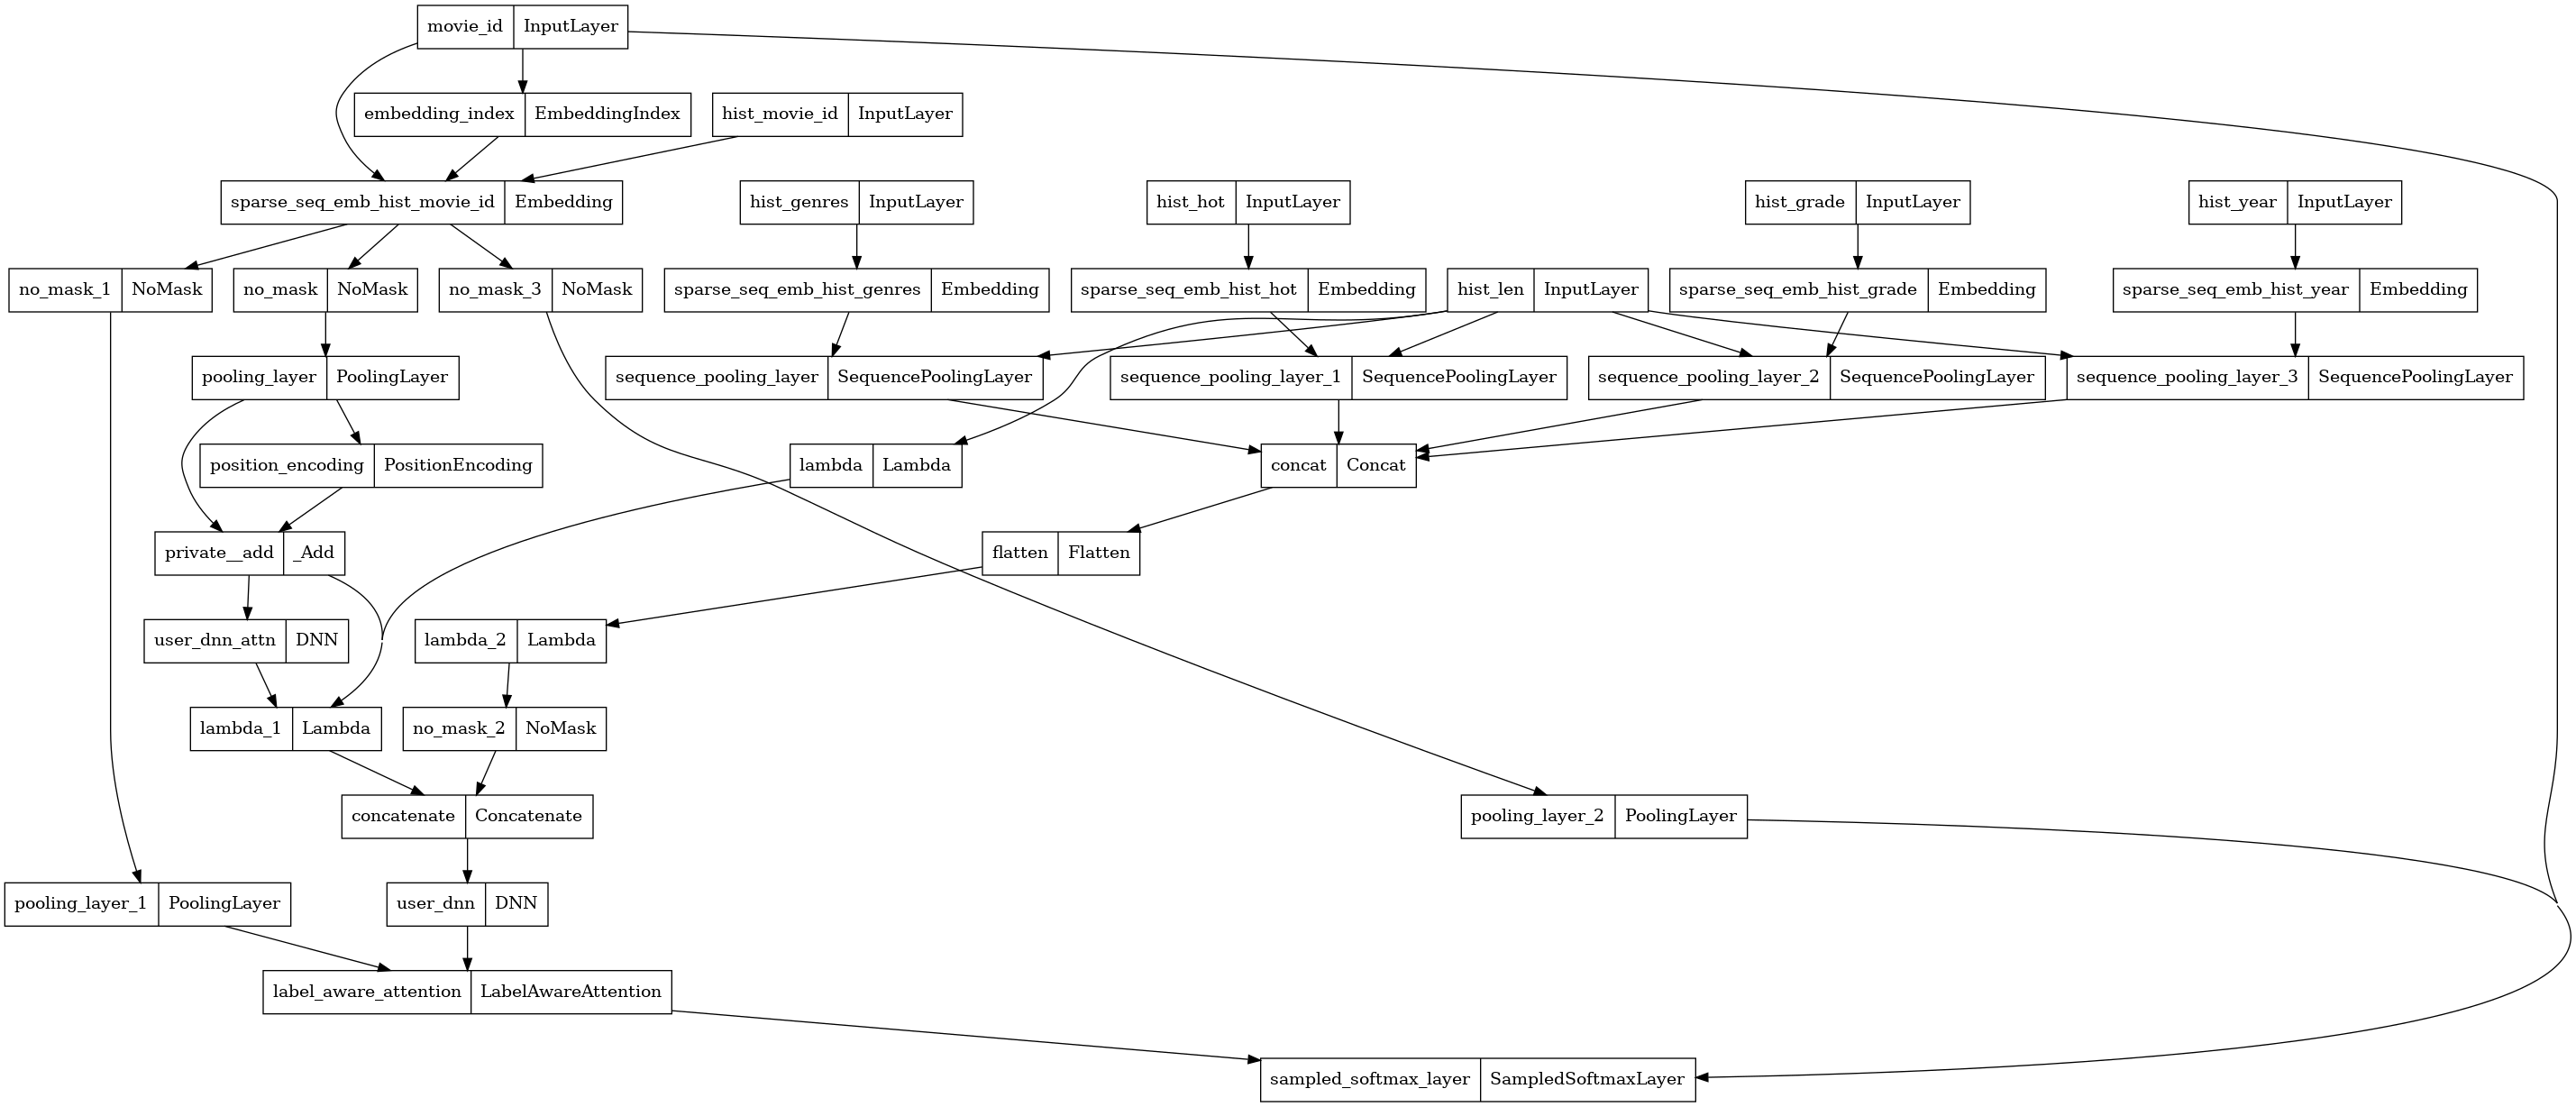

In [51]:
tf.keras.utils.plot_model(model)

In [118]:
save_model(model, 'model_25m_0421.h5')

In [ ]:
!poetry add pydot graphviz

In [1]:
from tensorflow.python.keras.models import  save_model,load_model
from deepmatch.layers import custom_objects

2024-04-21 13:18:04.817702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 13:18:04.873837: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 13:18:05.218525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-04-21 13:18:05.218557: W tensorflow/compiler/xl

In [2]:
model = load_model("model_25m_0421.h5", custom_objects)

2024-04-21 13:18:05.981997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-21 13:18:05.982012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pop-os
2024-04-21 13:18:05.982015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pop-os
2024-04-21 13:18:05.982083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.89.2
2024-04-21 13:18:05.982091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.89.2
2024-04-21 13:18:05.982092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.89.2
2024-04-21 13:18:05.982248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
import tensorflow as tf

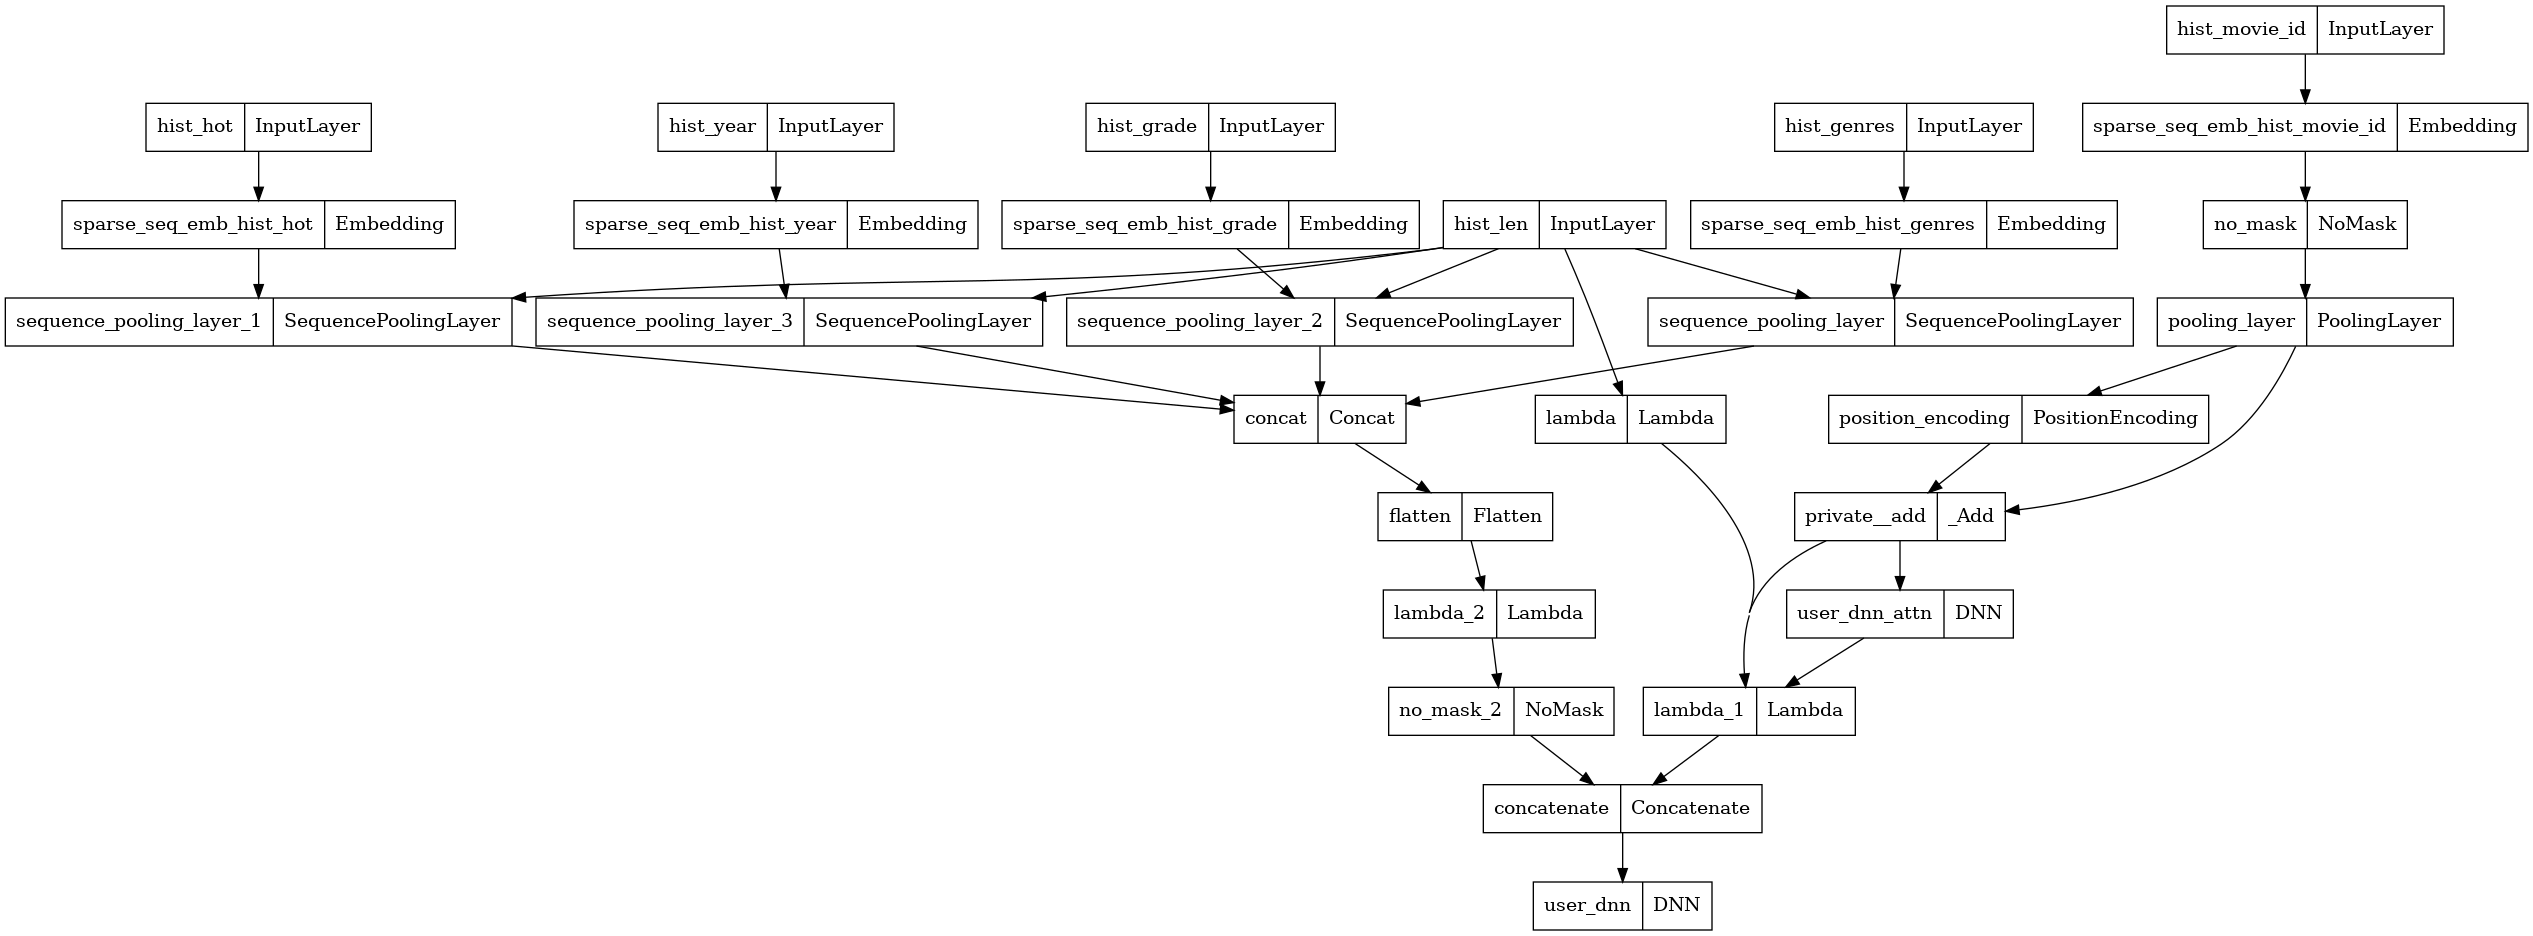

In [48]:
tf.keras.utils.plot_model(user_embedding_model)

## Test

In [144]:
all_movie_ids = movies["movie_id"]
metadatas = movies.to_dict(orient="records")

all_item_model_input = {"movie_id": all_movie_ids}

user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)

#user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
# user_embs = user_embs[:, i, :]  # i in [0,k_max) if MIND
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)

/root/.cache/pypoetry/virtualenvs/cinepaw-P6zxCTLW-py3.10/lib/python3.10/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-04-21 17:58:27.520572: W tensorflow/c/c_api.cc:291] Operation '{name:'lambda_26/Squeeze' id:17714 op device:{requested: '', assigned: ''} def:{{{node lambda_26/Squeeze}} = Squeeze[T=DT_FLOAT, _has_manual_control_dependencies=true, squeeze_dims=[1]](lambda_26/GatherV2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [145]:
user_embs = user_embedding_model.predict(test_model_input, batch_size=2 ** 12)

2024-04-21 17:58:27.729513: W tensorflow/c/c_api.cc:291] Operation '{name:'user_dnn_8/dropout_35/cond/Identity' id:17532 op device:{requested: '', assigned: ''} def:{{{node user_dnn_8/dropout_35/cond/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](user_dnn_8/dropout_35/cond)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [146]:
import chromadb
chroma_client = chromadb.PersistentClient(path="./chroma_data")
collection = chroma_client.get_or_create_collection("movie_rec_test")

In [147]:
movies["movie_id"] = movies["movieId"]

In [148]:
collection.delete(ids=all_movie_ids.apply(str).tolist())
collection = chroma_client.get_or_create_collection("movie_rec_test")
collection.add(ids=all_movie_ids.apply(str).tolist(), embeddings=item_embs, metadatas=metadatas)


In [149]:
# comi rec validate
count = 0
for i in tqdm(range(len(user_embs))):
    user_emb = user_embs[i:i+1]
    mids = [x["movieId"] for x in collection.query(query_embeddings=user_emb[:, 1, :], n_results=25)["metadatas"][0]] + \
    [x["movieId"] for x in collection.query(query_embeddings=user_emb[:, 0, :], n_results=25)["metadatas"][0]]
    target = movies[movies["movieId"]==test_model_input["movie_id"][i]]
    count += target["movieId"].tolist()[0] in mids



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:24<00:00, 246.61it/s]


In [151]:
count/6040

0.21092715231788078

In [89]:
# youtube DNN
count = 0
for i in tqdm(range(len(user_embs))):
    user_emb = user_embs[i:i+1]
    mids = [x["movieId"] for x in collection.query(query_embeddings=user_emb, n_results=20)["metadatas"][0]]
    target = movies[movies["movieId"]==test_model_input["movie_id"][i]]
    count += target["movieId"].tolist()[0] in mids

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:07<00:00, 780.19it/s]


In [90]:
count/6040

0.052152317880794705